Stoichiometric Screening with SMACT

This notebook provides a comprehensive guide to stoichiometric screening in materials informatics using SMACT (Semiconducting Materials by Analogy and Chemical Theory). We'll explore how to systematically screen chemical spaces for viable compounds using chemical rules and data-driven insights.

## Table of Contents
1. [Introduction to Stoichiometric Screening](#intro)
2. [Setup and Dependencies](#setup)
3. [Binary Screening](#binary)
4. [Ternary Screening (ABX₃ and Beyond)](#ternary)
5. [Quaternary Screening](#quaternary)
6. [Advanced Topics and Visualization](#advanced)
7. [Interactive Examples](#interactive)

## Learning Objectives
- Understand the principles of stoichiometric screening in materials discovery
- Learn how to use SMACT for systematic composition exploration
- Develop skills in high-throughput materials screening
- Master visualization techniques for chemical spaces
- Apply chemical rules and filters to narrow search spaces

## 1. Introduction to Stoichiometric Screening <a name="intro"></a>

Stoichiometric screening is a crucial step in materials discovery, allowing us to:
- Systematically explore vast chemical spaces
- Apply chemical rules to identify viable compositions
- Narrow down candidates for experimental synthesis
- Guide high-throughput computational studies

SMACT provides tools for this through:
- Chemical validity checks
- Oxidation state analysis
- Electronegativity rules
- Integration with materials databases

In [15]:
# Import required libraries
import os
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pymatgen.core import Composition
from mp_api.client import MPRester

# SMACT imports
import smact
from smact import Species
from smact.screening import smact_validity
from smact.oxidation_states import Oxidation_state_probability_finder
from smact.utils.oxidation import ICSD24OxStatesFilter

# For parallel processing
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 2. Setup and Helper Functions <a name="setup"></a>

First, let's define some helper functions that we'll use throughout the notebook:

In [16]:
def generate_compositions(elements, ratio, max_mult=2):
    """Generate compositions for a fixed stoichiometric ratio.
    
    Args:
        elements (list[str]): List of element symbols
        ratio (list[int]): The stoichiometric ratio
        max_mult (int): Maximum scaling factor
        
    Returns:
        list[Composition]: List of reduced compositions
    """
    compositions = []
    for mult in range(1, max_mult + 1):
        stoich = [r * mult for r in ratio]
        comp_dict = dict(zip(elements, stoich))
        comp = Composition(comp_dict).reduced_composition
        compositions.append(comp)
    return list(set(compositions))

def plot_binary_grid(df_binary, pair="Na-Cl", max_stoich=5):
    """Plot a binary composition grid showing valid stoichiometries.
    
    Args:
        df_binary (pd.DataFrame): DataFrame with binary screening results
        pair (str): Element pair to plot (e.g. 'Na-Cl')
        max_stoich (int): Maximum stoichiometry to show
    """
    subdf = df_binary[df_binary["pair"] == pair].copy()
    A, B = pair.split("-")
    
    grid = np.zeros((max_stoich, max_stoich), dtype=int)
    
    for _, row in subdf.iterrows():
        comp = row["composition"]
        countA = int(comp[A])
        countB = int(comp[B])
        grid[countA-1, countB-1] = 1 if row["valid_smact"] else -1
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(grid, cmap="RdYlGn", origin="lower")
    
    for i in range(max_stoich):
        for j in range(max_stoich):
            val = grid[i,j]
            text = "✓" if val == 1 else "×" if val == -1 else ""
            ax.text(j, i, text, va='center', ha='center', color="black", fontsize=14)
    
    ax.set_xlabel(f"{B} stoichiometric coefficient")
    ax.set_ylabel(f"{A} stoichiometric coefficient")
    ax.set_title(f"SMACT Validity Grid for {pair}")
    plt.colorbar(cax, ax=ax, label="1=Valid, -1=Invalid, 0=Unused")
    plt.show()

## 3. Binary Screening <a name="binary"></a>

Let's start with binary compounds, the simplest case of stoichiometric screening:

Binary screening results:
    pair composition reduced_formula  valid_smact
0  Na-Cl    (Na, Cl)            NaCl         True
1  Na-Cl    (Na, Cl)           NaCl2        False
2  Na-Cl    (Na, Cl)           NaCl3        False
3  Na-Cl    (Na, Cl)           NaCl4        False
4  Na-Cl    (Na, Cl)           Na2Cl        False


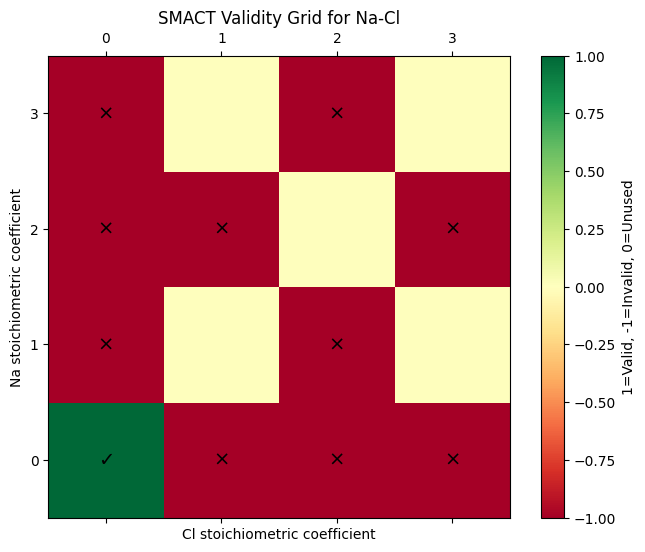

In [17]:
def binary_screening(element_list, max_stoich=5):
    """Screen binary compositions for validity.
    
    Args:
        element_list (list): List of elements to screen
        max_stoich (int): Maximum stoichiometry to consider
        
    Returns:
        pd.DataFrame: Results of binary screening
    """
    results = []
    
    for A, B in itertools.combinations(element_list, 2):
        for x in range(1, max_stoich+1):
            for y in range(1, max_stoich+1):
                comp = Composition({A: x, B: y}).reduced_composition
                valid = smact_validity(comp)
                results.append({
                    "pair": f"{A}-{B}",
                    "composition": comp,
                    "reduced_formula": comp.reduced_formula,
                    "valid_smact": valid
                })
    
    df = pd.DataFrame(results).drop_duplicates("reduced_formula").reset_index(drop=True)
    return df

# Example usage
binary_elements = ["Na", "Cl", "K", "Br"]
df_bin = binary_screening(binary_elements, max_stoich=4)

# Show results
print("Binary screening results:")
print(df_bin.head())

# Plot grid for Na-Cl
plot_binary_grid(df_bin, pair="Na-Cl", max_stoich=4)

## 4. Ternary Screening (ABX₃ and Beyond) <a name="ternary"></a>

Now let's explore ternary compounds, including the important ABX₃ stoichiometry found in perovskites:

In [18]:
def ternary_screening(elements_triplet, ratio=(1,1,3), max_mult=2):
    """Screen ternary compositions for a given stoichiometry ratio.
    
    Args:
        elements_triplet (list): Three elements to screen
        ratio (tuple): Target stoichiometry ratio (default: ABX₃)
        max_mult (int): Maximum multiplier for the ratio
        
    Returns:
        pd.DataFrame: Results of ternary screening
    """
    comps = generate_compositions(elements_triplet, ratio=ratio, max_mult=max_mult)
    
    data = []
    for c in comps:
        data.append({
            "elements_triplet": "-".join(elements_triplet),
            "composition": c,
            "reduced_formula": c.reduced_formula,
            "valid_smact": smact_validity(c)
        })
    return pd.DataFrame(data)

# Example: Screen for perovskite-like compounds
elements_ternary = ["Ca", "Ti", "O"]
df_tern = ternary_screening(elements_ternary, ratio=(1,1,3), max_mult=2)

print("\nTernary (ABX₃) screening results:")
print(df_tern)

# Create an interactive ternary plot
def plot_ternary(df, elements):
    """Create an interactive ternary plot of compositions."""
    def comp_to_frac(comp):
        amounts = [comp[el] for el in elements]
        total = sum(amounts)
        return [amt/total for amt in amounts]
    
    fracs = np.array([comp_to_frac(row["composition"]) for _, row in df.iterrows()])
    
    fig = go.Figure()
    
    # Add valid compositions
    valid_mask = df["valid_smact"]
    if valid_mask.any():
        valid_fracs = fracs[valid_mask]
        fig.add_trace(go.Scatterternary(
            a=valid_fracs[:,0], b=valid_fracs[:,1], c=valid_fracs[:,2],
            mode="markers",
            marker=dict(size=10, color="green", symbol="circle"),
            name="Valid"
        ))
    
    # Add invalid compositions
    invalid_mask = ~valid_mask
    if invalid_mask.any():
        invalid_fracs = fracs[invalid_mask]
        fig.add_trace(go.Scatterternary(
            a=invalid_fracs[:,0], b=invalid_fracs[:,1], c=invalid_fracs[:,2],
            mode="markers",
            marker=dict(size=10, color="red", symbol="x"),
            name="Invalid"
        ))
    
    fig.update_layout(
        title=f"Ternary Composition Space: {'-'.join(elements)}",
        ternary=dict(
            aaxis=dict(title=elements[0]),
            baxis=dict(title=elements[1]),
            caxis=dict(title=elements[2])
        )
    )
    
    fig.show()

plot_ternary(df_tern, elements_ternary)


Ternary (ABX₃) screening results:
  elements_triplet  composition reduced_formula  valid_smact
0          Ca-Ti-O  (Ca, Ti, O)          CaTiO3         True


## 5. Quaternary Screening <a name="quaternary"></a>

Finally, let's implement quaternary screening:

In [19]:
def quaternary_screening(elements_quad, max_stoich=3):
    """Screen quaternary compositions.
    
    Args:
        elements_quad (list): Four elements to screen
        max_stoich (int): Maximum stoichiometry to consider
        
    Returns:
        pd.DataFrame: Results of quaternary screening
    """
    results = []
    
    for x, y, z, w in itertools.product(range(1, max_stoich+1), repeat=4):
        comp_dict = dict(zip(elements_quad, [x,y,z,w]))
        comp = Composition(comp_dict).reduced_composition
        
        valid = smact_validity(comp)
        results.append({
            "quad": "-".join(elements_quad),
            "composition": comp,
            "reduced_formula": comp.reduced_formula,
            "valid_smact": valid
        })
    
    df = pd.DataFrame(results).drop_duplicates("reduced_formula").reset_index(drop=True)
    return df

# Example usage
elements_quad = ["Cu", "Ti", "O", "N"]
df_quad = quaternary_screening(elements_quad, max_stoich=2)

print("\nQuaternary screening results:")
print(df_quad.head())

# Summary statistics
valid_count = df_quad["valid_smact"].sum()
total_count = len(df_quad)
print(f"\nFound {valid_count} valid compositions out of {total_count} total combinations")


Quaternary screening results:
        quad     composition reduced_formula  valid_smact
0  Cu-Ti-O-N  (Cu, Ti, O, N)          TiCuNO         True
1  Cu-Ti-O-N  (Cu, Ti, O, N)         TiCuN2O         True
2  Cu-Ti-O-N  (Cu, Ti, O, N)         TiCuNO2         True
3  Cu-Ti-O-N  (Cu, Ti, O, N)       TiCu(NO)2         True
4  Cu-Ti-O-N  (Cu, Ti, O, N)         Ti2CuNO         True

Found 15 valid compositions out of 15 total combinations


## 6. Advanced Topics and Visualization <a name="advanced"></a>

Let's explore some advanced features of SMACT:


Most common oxidation states in ICSD:
  species  results_count
0     O2-         116910
1      H+          34232
2    Si4+          18248
3     Na+          17539
4    Ca2+          16605
5    Al3+          15020
6    Ba2+          14917
7     N3-          13983
8      K+          13748
9     S2-          13417


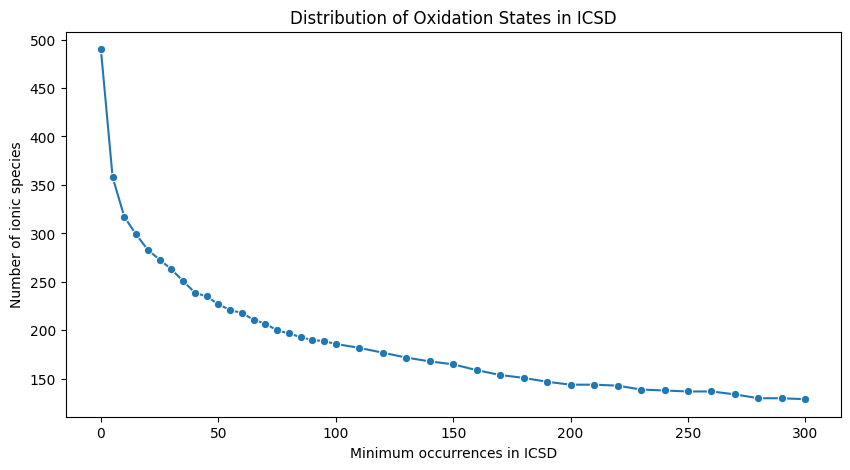

In [20]:
# Initialize the ICSD oxidation state filter
ox_filter = ICSD24OxStatesFilter()

# Get species occurrences
sorted_occ_df = ox_filter.get_species_occurrences_df(sort_by_occurrences=True)
print("\nMost common oxidation states in ICSD:")
print(sorted_occ_df.head(10))

# Plot oxidation state distribution
plt.figure(figsize=(10, 5))
thresholds = list(range(0, 101, 5)) + list(range(100, 301, 10))
species_counts = [len(ox_filter.get_species_list(threshold=t)) for t in thresholds]

sns.lineplot(x=thresholds, y=species_counts, marker="o")
plt.xlabel("Minimum occurrences in ICSD")
plt.ylabel("Number of ionic species")
plt.title("Distribution of Oxidation States in ICSD")
plt.show()

## 7. Interactive Examples <a name="interactive"></a>

Try modifying these parameters to explore different chemical spaces:

In [21]:
import ipywidgets as widgets

# Create interactive widgets
element_a = widgets.Dropdown(options=['Na', 'K', 'Rb', 'Cs'], description='A:')
element_b = widgets.Dropdown(options=['Cl', 'Br', 'I'], description='B:')
max_stoich = widgets.IntSlider(min=2, max=8, value=4, description='Max Stoich:')

def update_plot(a, b, max_s):
    df = binary_screening([a, b], max_stoich=max_s)
    plot_binary_grid(df, pair=f"{a}-{b}", max_stoich=max_s)

widgets.interactive(update_plot, a=element_a, b=element_b, max_s=max_stoich)

interactive(children=(Dropdown(description='A:', options=('Na', 'K', 'Rb', 'Cs'), value='Na'), Dropdown(descri…